<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/WS1_W2024_students_5823.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Workshop #1 - Binary Choice ⚖️</font>


# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks, and wet questions in code blocks.
* Submission guidelines:
    * When you're done, restart the notebook, and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Add a text block in the beginning of your notebook with your IDs.
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 01/12/2024, 10:00
* For any questions regarding this workshop task, contact [Eden](mailto:edens@campus.technion.ac.il).


# Introduction


* **Setting**: In the binary choice setting, users $u\in U$ make a binary decision of whether or not to consume items $x \in X$. Each item is represented by a vector $x\in\mathbb{R}^n$, and the outcome is represented using binary variable $y\in\left\{0,1\right\}$, such that $y=1$ when the user chose to consume the item.


Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sklearn.metrics
import sklearn.linear_model
import sklearn.metrics

from tqdm.auto import tqdm

## Abstract population models
For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. These are similar to the abstract classes defined in HW1.

As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

🔵 Run the cell below to define the `DiscreteChoiceEnvironment` and `InnerProductTrueValueEnvironment` classes:

In [2]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 16
    observations_per_user = 10
    n_users_eval = 50

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )

    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError

    def _generate_choice_dataset(self, n_users, uid_offset):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = i+uid_offset
                for k in range(self.n_features):
                        dct[f'x{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df

    def generate_train_eval_datasets(self, n_users_train):
        return (
            self._generate_choice_dataset(n_users_train, uid_offset=0),
            self._generate_choice_dataset(self.n_users_eval, uid_offset=n_users_train),
        )

    @property
    def feature_columns(self):
        return [
            f'x{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value


# Task \#1: Prediction with stated and revealed preferences


## Introduction

In our first task, we will investigate the relation between predictive performance and the type of feedback obtained from users.

We assume that consumption decisions are made according to the a random utility model. Each user is represented by a vector $u\in\mathbb{R}^d$, and each item is represented by a vector $x\in\mathbb{R}^d$. The true utility experienced by user $u$ from consuming item $x$ is assumed to be the inner product $v_u(x)=u^Tx$. We denote the indicator function by $\mathbb{1}(\cdot)\in\{0,1\}$.


We distinguish between three types of feedback:

* **Rational preference**: When user $u$ is queried in an ideal environment, they choose to consume the item if its utility is larger than zero. Their rational choice is to consume if the utility is larger than zero, hence $y_\mathrm{rational} = \mathbb{1}(v_u(x) \ge 0)$.

* **Stated preference**: When user $u$ is questioned explicitly about item $x$ (e.g in a survey), they tend to under-estimate the value of the item. Therefore, their stated consumption choice is given by $y_\mathrm{stated} = \mathbb{1}(v_u(x)-b \ge 0)$, where $b\ge 0$ is a fixed and latent bias term.

* **Revealed preference**: When $u$ is presented with item $x$, they reply according to a noisy evaluation $y_\mathrm{revealed} = \mathbb{1}(v_u(x)+\varepsilon \ge 0)$, where $\varepsilon\sim N(0,\sigma)$.



## Exercise 1.1: Simulating user behavior

The `NoisyBinaryChoiceEnvironment` class implements the preference models described above, and will be used for dataset generation.
The class inherits from the `InnerProductTrueValueEnvironment` class defined above, and provides a simple interface which will be useful for simulation.



In [3]:
class NoisyBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self, noise_scale, stated_preference_bias):
        self.noise_scale = noise_scale
        self.stated_preference_bias = stated_preference_bias

    def _choice(self, users, items):
        true_value = self._true_value(users, items)
        decision_noise = np.random.normal(
            size=true_value.shape,
            scale=self.noise_scale,
        )
        stated_value = true_value-self.stated_preference_bias
        perceived_value = true_value + decision_noise
        return {
            'true_value': true_value,
            'rational_choice': true_value >= 0,
            'stated_choice': stated_value >= 0,
            'revealed_choice': perceived_value >= 0,
        }

In [4]:
np.random.seed(42)



As an example, here we instantiate an environment with noise magnitude $\sigma=2$ and bias $b=1$ for stated preferences. We generate training and evaluation datasets with 100 users for training. Note that the training and evaluation datasets are pandas DataFrames:

In [5]:
example_noisy_choice_env = NoisyBinaryChoiceEnvironment(
    noise_scale=2,
    stated_preference_bias=1,
)
example_train_df, example_eval_df = example_noisy_choice_env.generate_train_eval_datasets(
    n_users_train=100,
)
example_train_df.head()

,user_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x10,x11,x12,x13,x14,x15,true_value,rational_choice,stated_choice,revealed_choice
0,0,-0.182896,1.374876,-0.645964,-0.799192,-0.482744,-0.953329,0.122670,1.624678,0.323079,...,-0.291811,-1.563191,0.883110,-0.077837,-0.180480,3.193108,2.023066,True,True,True
1,0,0.298753,-0.751791,-0.426358,1.148446,0.113270,-1.438278,0.919229,-0.668144,1.873298,...,-0.447322,1.281016,0.067856,0.852774,0.484733,-0.846357,3.572798,True,True,True
2,0,-0.643550,1.029961,-0.334775,-0.403648,-0.955123,0.423599,2.062525,-1.067533,0.024219,...,-0.079641,0.452372,-1.062394,0.428307,-0.187144,0.985730,2.139304,True,True,False
3,0,1.187386,2.589564,0.579633,0.325796,0.194384,-0.353166,0.338484,-0.295401,0.168461,...,-1.006543,1.139879,1.317115,-0.118069,-2.121855,-0.607822,5.312056,True,True,True
4,0,1.296995,-0.022868,-0.999302,-0.504775,0.840620,0.546734,-0.238932,-0.366824,-0.391758,...,1.615376,-0.322320,1.217159,1.521316,0.998311,-0.431620,3.159415,True,True,False


We extract features and train models using `sklearn`. Here we use the training set to fit a Logistic Regression model, and predict on the evaluation set:

In [6]:
example_model = sklearn.linear_model.LogisticRegression().fit(
    X=example_train_df[example_noisy_choice_env.feature_columns],
    y=example_train_df['revealed_choice'],
)
# Predict outcomes for first 10 rows
example_model.predict(
    X=example_eval_df.iloc[:10][example_noisy_choice_env.feature_columns],
)

array([False, False,  True,  True,  True, False, False,  True, False,
       False])

**Warm-up question**:

In the `example_eval_df` dataset:
* What is the proportion of positive consumption choices under the `rational_choice` criteria ($y_\mathrm{rational}=1$)?
* What is the proportion of positive consumption choices under the `stated_choice` criteria ($y_\mathrm{stated}=1$)?
* What is the proportion of positive consumption choices under the `revealed_choice` criteria ($y_\mathrm{revealed}=1$)?

🔵 **Answer**:

In [8]:
## YOUR SOLUTION
# get the rational_choice column from the example_eval_df
# and calculate the percentage of rational choices
rational_percentage = example_eval_df[example_eval_df['rational_choice']].shape[0] / example_eval_df.shape[0]
stated_percentage = example_eval_df[example_eval_df['stated_choice']].shape[0] / example_eval_df.shape[0]
revealed_percentage = example_eval_df[example_eval_df['revealed_choice']].shape[0] / example_eval_df.shape[0]
print(f'Rational choice: {rational_percentage}')
print(f'Stated choice: {stated_percentage:.2f}')
print(f'Revealed choice: {revealed_percentage:.2f}')


Rational choice: 0.488
Stated choice: 0.39
Revealed choice: 0.51


## Exercise 1.2: Comparison graph

If users make consumption decisions in alignment with $y_\mathrm{revealed}$, which signal would be most effective for training the prediction model?

Plot three lines (on the same axes) representing the accuracy of a logistic regression model, for variable $\sigma$. Plot one line graph for *stated preferences*, and another line for *revealed preferences*.  

For each decision noise magnitude $\sigma$ in range $\sigma\in[0.1,10]$:
* Instantiate a `NoisyBinaryChoiceEnvironment` environment with the given noise magnitude, and set the bias term as $b=1$.
* Generate training/evaluation datasets with `n_users_train=20`.
* Use the training set to train three Logistic Regression models, using $y_\mathrm{rational}$, $y_\mathrm{stated}$ and $y_\mathrm{revealed}$ as training labels.
* For each trained model, evaluate test accuracy on the task of predicting $y_\mathrm{revealed}$.

To reduce randomization noise, repeat the experiment 50 times for each $\sigma$, and average the results.

Hints:
* Code should be simple and concise. Separation between data collection and data analysis usually makes it easier to debug.
* Start with a small number of repetitions to make the debugging cycle quicker, and increase the number of repetitions to the final value when you are ready for analysis.
* Given an environment `env` and a generated dataset `train_df`:
  * `train_df['rational_choice']` is the user's rational choice $y_\mathrm{rational}$. Similarly for $y_\mathrm{stated}$, $y_\mathrm{revealed}$.
  * `train_df[env.feature_columns]` extracts the feature columns from the DataFrame.
* Use `sklearn.linear_model.LogisticRegression` as the prediction model:
  * Note that `pandas.DataFrame` and `pandas.Series` are valid datatypes for sklearn's `X` and `y` arguments, so is no need to convert the objects returned by `env.generate_train_eval_datasets`.
  * Given a trained Logistic Regression model `m`, the command `m.score(X,y)` returns the mean accuracy on the given test data and labels.
* Figures should be clear and organized. Make sure that title, axis labels, and legend are added and clearly labeled.

🔵 **Answer**:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

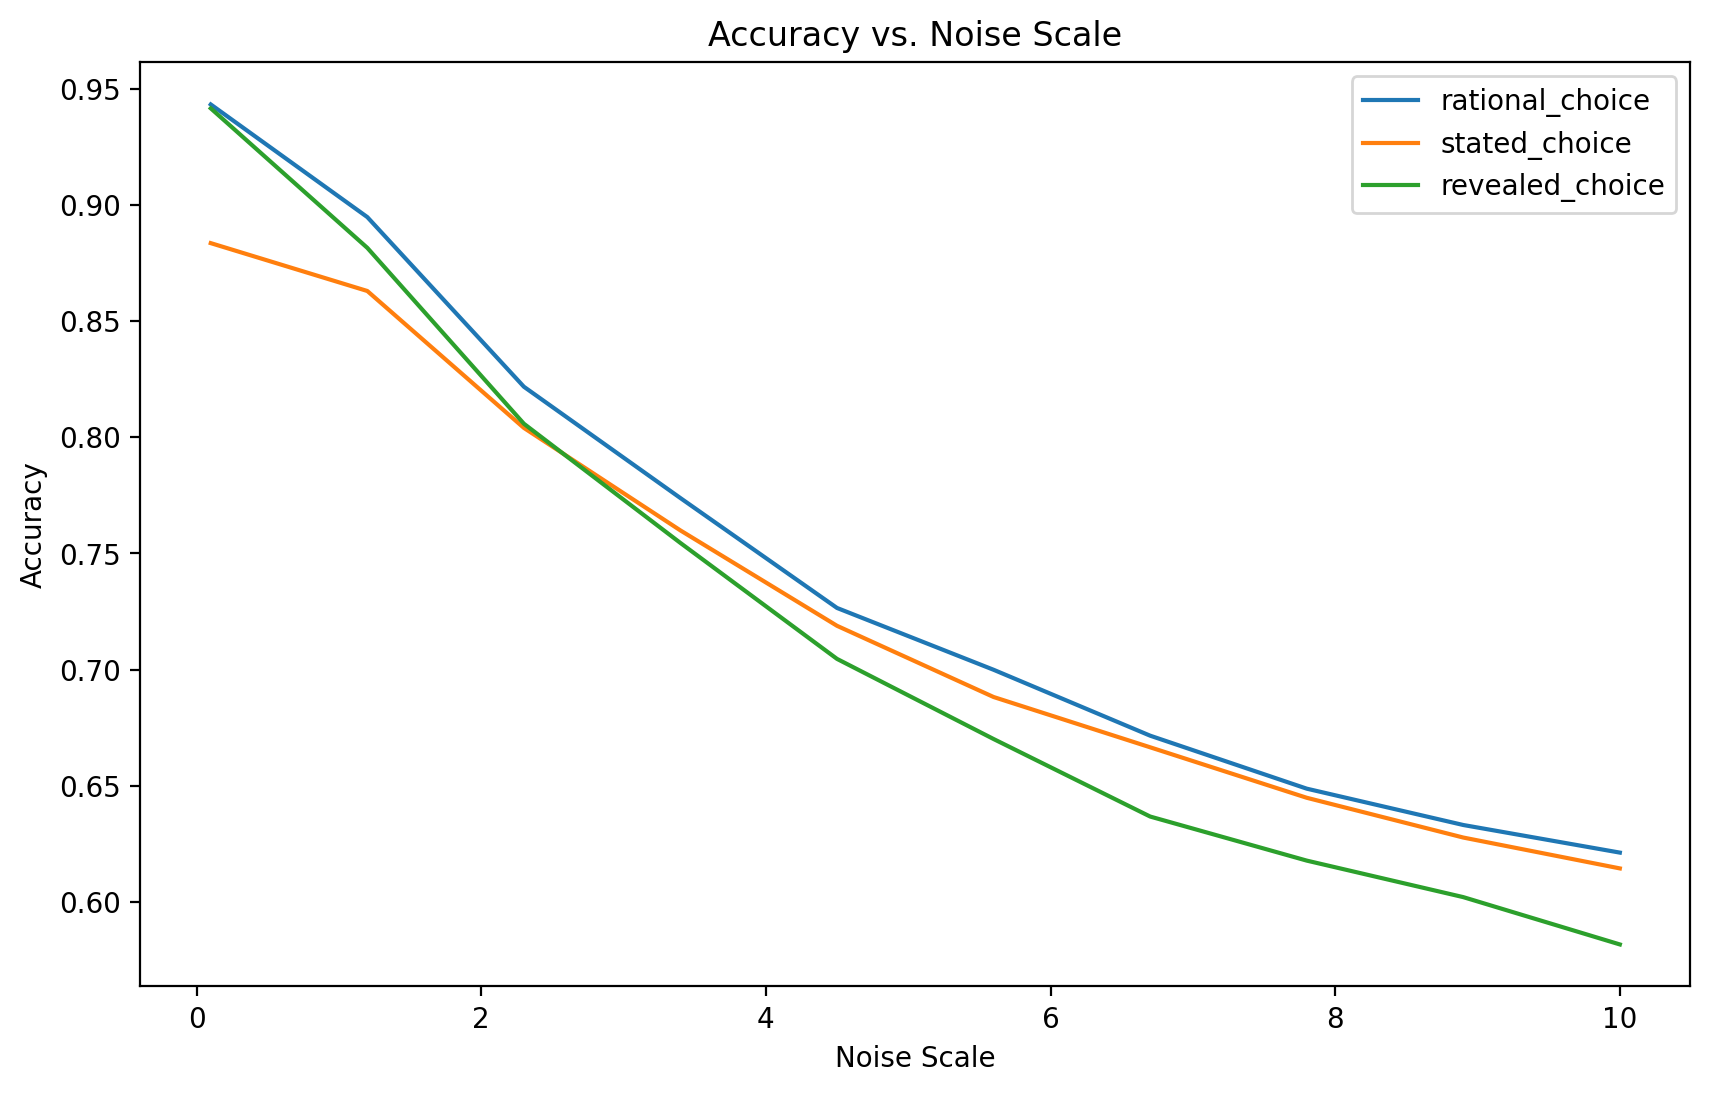

In [23]:
noise_scale_vec = np.linspace(0.1,10,10)
task12_n_repetitions = 50
task12_n_users = 20

## YOUR SOLUTION

labels = ['rational_choice', 'stated_choice', 'revealed_choice']
eval_label = 'revealed_choice'


def get_accs_for_scale(noise_scale):
    noisy_choice_env = NoisyBinaryChoiceEnvironment(
        noise_scale=noise_scale,
        stated_preference_bias=bias,
    )
    train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(
        n_users_train=task12_n_users
    )
    accuracies = {}
    for label in labels:
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[noisy_choice_env.feature_columns],
            y=train_df[label],
        )
        accuracies[label] = model.score(eval_df[noisy_choice_env.feature_columns], eval_df[eval_label])
    return accuracies
    
def plot_graph(labels_dfs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    
    for label, label_df in labels_dfs.items():
        plt.plot(label_df.index, label_df['accuracy'], label=label)
    plt.xlabel('Noise Scale')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Noise Scale')
    plt.legend(labels)
    plt.show()

bias = 1
noise_scale_graphs = {}
label_graph = { label: pd.DataFrame() for label in labels}
for noise_scale in noise_scale_vec:
    accuracies = { label: [] for label in labels}
    for _ in tqdm(range(task12_n_repetitions)):
        accuracies_for_n_repetitions = get_accs_for_scale(noise_scale)
        for label in labels:
            accuracies[label].append(accuracies_for_n_repetitions[label])
    accuracies_mean = {label: np.mean(accuracies[label]) for label in labels}
    for label in labels:
        label_graph[label].loc[noise_scale, 'accuracy'] = accuracies_mean[label]
    
plot_graph(label_graph)
# for label in labels:
#     plot_graph(label_graph[label], label)
    
        
        

Explain the results in detail. In your answer, relate to:
* Overall trends:
  * Are the lines increasing/decreasing/constant as a function of $\sigma$? Why?
* Relation between the lines:
  * Assuming that $y_\mathrm{rational}$ can't be measured in practice -
  Which of the remaining training labels ($y_\mathrm{stated}$, $y_\mathrm{revealed}$) is better when $\sigma\to 0$? which is better when $\sigma\to \infty$? Why?
  * If lines cross each other, when and why do they cross?
  * If lines coincide, when and why do they coincide?
* Range of values:
  * What is the range of accuracy values obtained?
  * How do they relate to upper/lower bounds of predictive performance?




🔵 **Answer**:

(YOUR SOLUTION)

After describing your observations, try to answer the initial question: If users make consumption decisions in alignment with $y_\mathrm{revealed}$, which signal would be most effective for training the prediction model?



🔵 **Answer**:

(YOUR SOLUTION)

## Exercise 1.3: Evaluating Welfare

Plot a similar graph for the welfare metric you created in HW1:

$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$

🔵 **Answer**:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

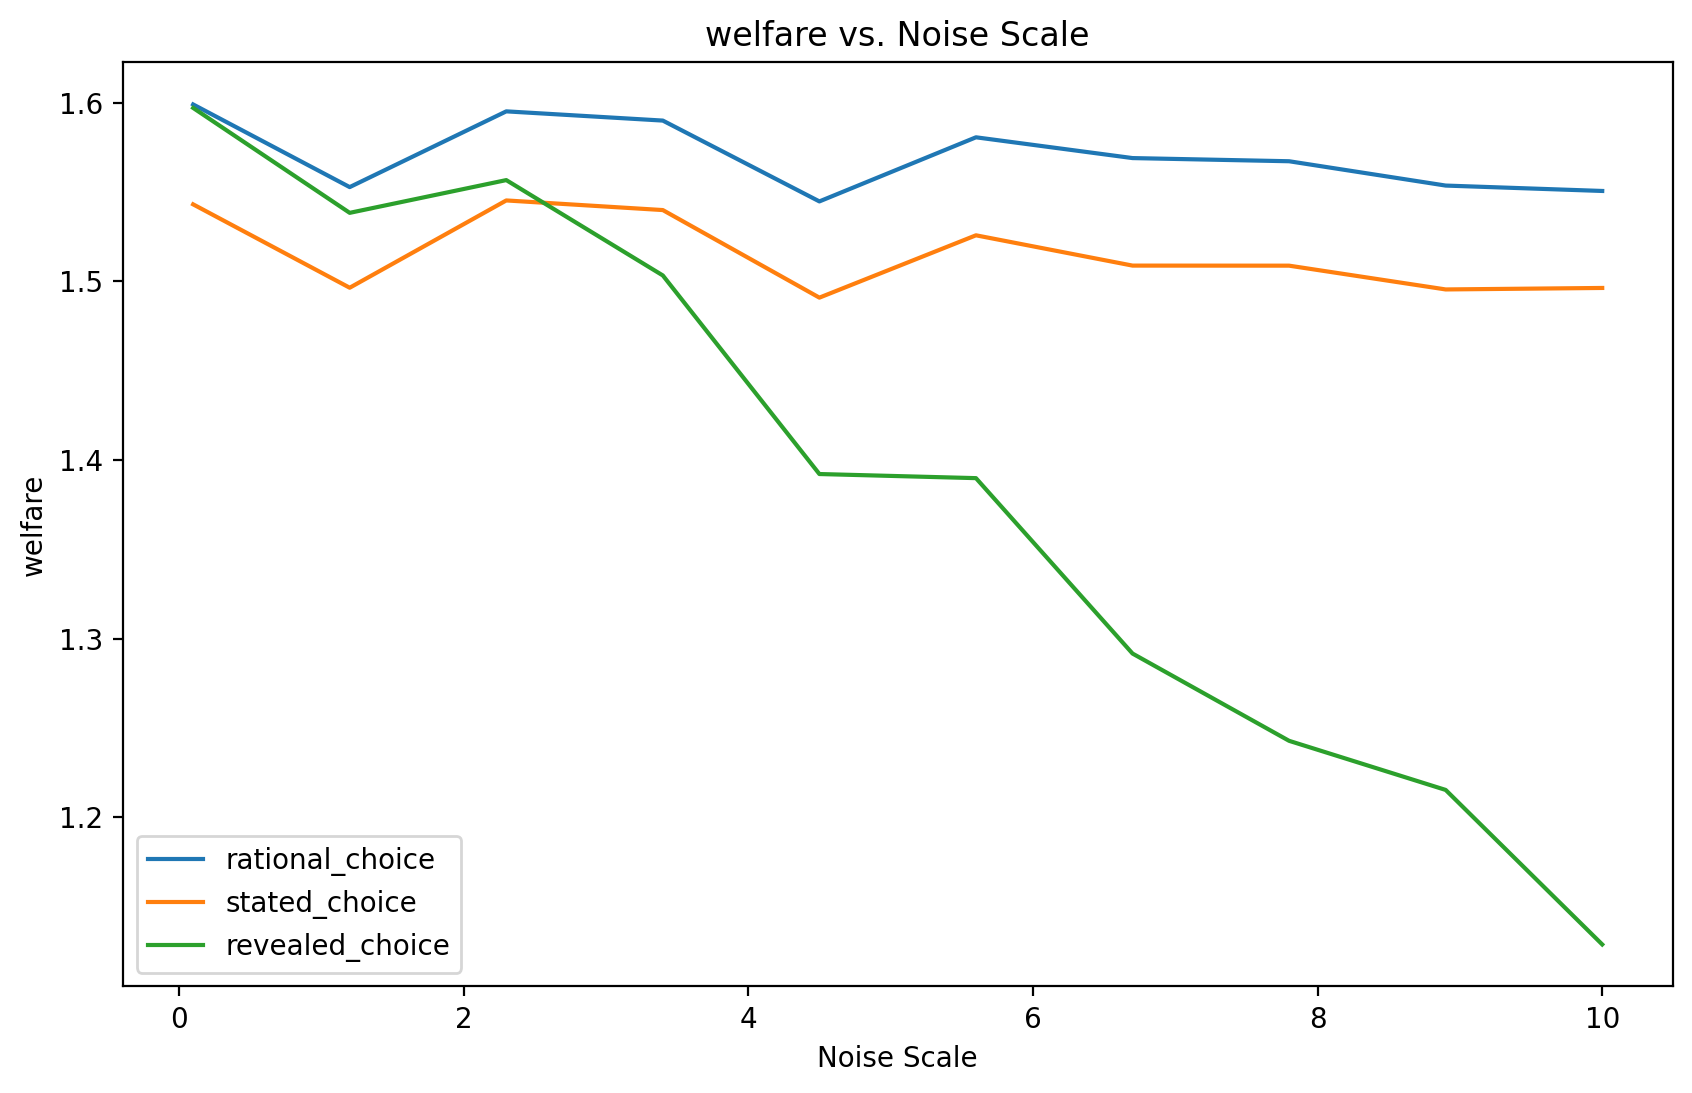

In [28]:
## YOUR SOLUTION

def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set

    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.feature_columns`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
    ## YOUR SOLUTION
    eval_df['f_x'] = f(eval_df[feature_columns])
    eval_df['welfare'] = eval_df['f_x'] * eval_df[value_column]
    return eval_df['welfare'].mean()

def get_welfare_for_scale(noise_scale):
    noisy_choice_env = NoisyBinaryChoiceEnvironment(
        noise_scale=noise_scale,
        stated_preference_bias=bias,
    )
    train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(
        n_users_train=task12_n_users
    )
    welfares = {}
    for label in labels:
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[noisy_choice_env.feature_columns],
            y=train_df[label],
        )
        f = lambda x: model.predict(x)
        welfares[label] = welfare(f, eval_df, noisy_choice_env.feature_columns, 'true_value')
    return welfares
    
def plot_graph(labels_dfs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    
    for label, label_df in labels_dfs.items():
        plt.plot(label_df.index, label_df['welfare'], label=label)
    plt.xlabel('Noise Scale')
    plt.ylabel('welfare')
    plt.title('welfare vs. Noise Scale')
    plt.legend(labels)
    plt.show()

bias = 1
noise_scale_graphs = {}
label_graph = { label: pd.DataFrame() for label in labels}
for noise_scale in noise_scale_vec:
    welfares = { label: [] for label in labels}
    for _ in tqdm(range(task12_n_repetitions)):
        welfares_for_n_repetitions = get_welfare_for_scale(noise_scale)
        for label in labels:
            welfares[label].append(welfares_for_n_repetitions[label])
    welfares_mean = {label: np.mean(welfares[label]) for label in labels}
    for label in labels:
        label_graph[label].loc[noise_scale, 'welfare'] = welfares_mean[label]
    
plot_graph(label_graph)

Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)

## Exercise 1.4: Welfare counter-example

**Assuming we use a linear classifer** (i.e. $f(x) = \mathrm{sign}(w^Tx + b)$)

Find a dataset for which the classifier which yields the best accuracy, does not promote optimal welfare. Explain your answer.

In your answer, you should provide:
* Items and features
* Utility function (utility doen't have to be linear)
* Present a classifier, and explain why it's optimal in terms of accuracy.
* Present another classifier which may have worse accuracy but better welfare.

Note: you can sketch a 1D/2D dataset using Power-Point (taking a screenshot), or through this website: https://app.diagrams.net/. Describe the solution in words below.

Attach the diagram inside a zip file together with your notebook when you submit your solution.

🔵 **Answer**:

General idea: One Item, Ten users. for users 1...9 the true value is -1. for user=10 the true value is 1000.

## Exercise 1.5: Mixed signals
Consider the following scenario:
You manage a recommendation system and have a dataset capturing the consumption choices ($y_\mathrm{revealed}$) of 10 users.
Since this is a small user base (even with multiple observations per user), you are offered the opportunity to gather additional survey data. The survey provides information about items and consumption decisions, assuming that users answer the survey according to $y_\mathrm{stated}$. You can survey up to 30 additional users. How many users should you include in the survey?

Assume a `NoisyBinaryChoiceEnvironment` with $\sigma=0.1$ and $b=1$. Support your claims with data, and explain your results.

Hints:
* The dataframes generated by `env.generate_train_eval_datasets` include a `user_id` column. Training set user IDs are numbered consecutively from `0` to `n_users_train-1` (inclusive).
* Evaluate survey sizes in increments of 5 by iterating over the vector provided below.
* To minimize estimation noise, repeat the experiment 100 times and average the results.

🔵 **Answer**:


In [ ]:
task_15_n_revealed = 10
task_15_n_additional_users_vec = np.arange(0,31,5)
task_15_n_repetitions = 100

## YOUR SOLUTION

Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)

Without additional computations, how would your answer change if $b=0$ or $b\to \infty$? If changes occur, explain how and why, providing justification for your reasoning.



🔵 **Answer**:

(YOUR SOLUTION)

# Task \#2: Irrational choice predition

## Introduction

In this task, we will evaluate the performance of a standard ("rational") prediction model when decision-makers are loss-averse.

In this section, users make decisions under uncertainty. Each user is associated with two utility functions, $u_a$ and $u_b$, and a probability parameter $p\in\left[0,1\right]$. The user's utility from consuming an item $x$ is:
- $u_a(x)\in\mathbb{R}$ with probability $p$, and
- $u_b(x)\in\mathbb{R}$ with probability $(1-p)$.

When user behavior is *rational*, the decision is made by comparing the *expected utility* of the two alternatives:

$$
y_\text{rational}=\begin{cases}
1&p \cdot u_a(x) + (1-p) \cdot u_b(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

When user decisions are subject to *behavioral bias*, choice deviates from the expected optiumum. In particular, we will focus on a setting where the users are *loss-averse*. In the spirit of [Prospect Theory](https://en.wikipedia.org/wiki/Prospect_theory), we assume there exist two functions $\pi, v$ such that the perceived value from consuming the item is:

$$
\begin{align}
V_{\pi, v}\left(x\right)
&=\sum_i \pi\left(p_i\right) v\left(u_i(x)\right)\\
&=\pi(p) \cdot v(u_a(x)) + \pi(1-p) \cdot v(u_b(x))
\end{align}
$$

The function $v$ captures the loss-aversion property, and it is s-shaped and asymmetrical. The function $\pi$ is a probability weighting function and captures the idea that people tend to overreact to small probability events, but underreact to large probabilities. Assuming $v(0)=0$, consumption decisions are made according to the following rule:

$$
y_\text{prospect}=\begin{cases}
1&V_{\pi,v}(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

## Exercise 2.1: The functional form of $v$


The user valuation bias can be modeled using an S-shaped assymetrical function $v:\mathbb{R}\to\mathbb{R}$. Following [Maggi (2004, Section 4.1)](https://www.econstor.eu/bitstream/10419/87132/1/472515071.pdf), we assume that $v$ is a power S-shaped utility function, and its functional form is given by:


$$
v(u)=\begin{cases}
u^\alpha& u \ge 0 \\
-\gamma \left(-u\right)^\beta& u < 0
\end{cases}
$$

where $u=u(x)$ is the objective utility from consuming item $x$, and $0< \alpha \le \beta \le 1$, $\gamma\ge 1$ are constants.


**Implementation**

Implement the class `PowerLossAversion`. The class constructor will receive three scalar constants `alpha`, `beta`, `gamma`.  The `__call__` function will calculate $v(u)$ as defined above.

Hint: Make your code concise and more efficient by using numpy vectorized operations. Try to avoid explicit loops and `if` statements.

🔵 **Answer**:

In [29]:
class PowerLossAversion:
    """
    The power S-shaped utility function, as defined by Maggi (2014)
    """
    def __init__(self, alpha, beta, gamma):
        assert 0 < alpha <= 1
        assert 0 < beta <= 1
        assert alpha <= beta
        assert gamma >= 1
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def __call__(self, u: np.ndarray):
        """
        Compute the power S-shaped utility function for a vector of utilities.

        Parameters
        ----------
        u : ndarray of shape (n)

        Output
        ------
        v : ndarray of shape (n)
        """
        ## YOUR SOLUTION
        v = u.copy()
        v[u >= 0] = u[u >= 0] ** alpha
        v[u<0] = (-gamma) * (-u[u<0]) ** beta
        return v

Using the implementation above, plot the function $\nu$ for values of $u$ in the range $[-2,2]$, and for the given sets of parameters:

  1. $\left(\alpha_1, \beta_1, \gamma_1\right) = \left(1, 1, 1\right)$
  2. $\left(\alpha_2, \beta_2, \gamma_2\right) = \left(1, 1, 2.5\right)$
  3. $\left(\alpha_3, \beta_3, \gamma_3\right) = \left(0.88, 0.88, 2.5\right)$
  4. $\left(\alpha_4, \beta_4, \gamma_4\right) = \left(0.2, 0.88, 1.8\right)$

🔵 **Answer**:

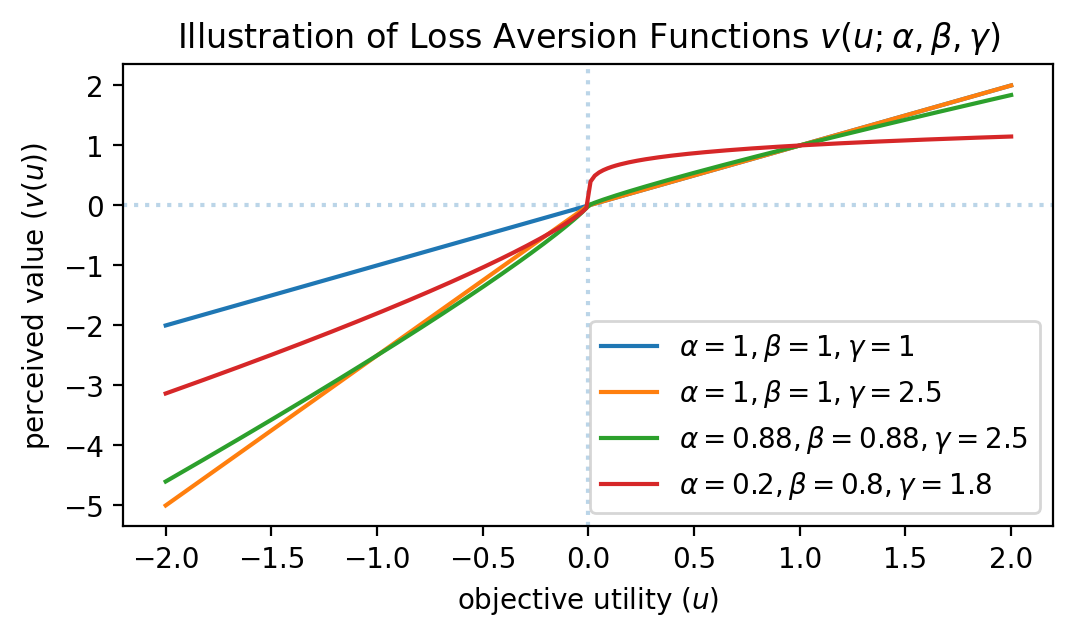

In [30]:
prospect_params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
]

fig,ax = plt.subplots(figsize=(6,3))

u_vec = np.linspace(-2,2,200)
for alpha, beta, gamma in prospect_params_lst:
    v = PowerLossAversion(alpha, beta, gamma)
    perceived_value = v(u_vec)
    ax.plot(
        u_vec,
        perceived_value,
        label=f'$\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$',
    )

ax.set_title('Illustration of Loss Aversion Functions $v(u; \\alpha, \\beta, \\gamma)$')
ax.set_xlabel('objective utility ($u$)')
ax.set_ylabel(r'perceived value ($v(u)$)')
ax.axhline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.axvline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.legend()

Given the results -

What type of behavior is characterized by the curve parametrized by $\left(\alpha, \beta, \gamma\right) = \left(1, 1, 1\right)$?

🔵 **Answer**:

complete rational preception of value without loss-aversion



What is the interpretation of the parameter $\gamma$? Which behavioral traits are represented by high/low values of $\gamma$? What aspect of prospect theory does it correspond to?

🔵 **Answer**:

higher gamma gives higher slope in the negative section, in contrast to the positive slope that is uneffected. The interpability is that higher gamma indicates higher sensitivity of a given user to loss. So user with high gamma will fear loss and try to minimize it as much as possible, even at a cost of possible great reward.


What is the meaning of the parameters $\alpha,\beta$? What aspects of prospect theory do they correspond to?

🔵 **Answer**:

alpha and beta is the relationship between how sensitive a user is to a loss in general and the preseption to how much increased loss is relevant to him as aposed to just loss in general.


## Exercise 2.2: Simulating user behavior

**Example**

For the implementation of this behavioral model, we inherit from the `InnerProductTrueValueEnvironment` defined at the start of this notebook, and define the following abstract class:



In [31]:
class ProspectEnvironment(InnerProductTrueValueEnvironment):
    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        """
        return np.stack(
            [
                np.random.normal(
                    loc=1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
                np.random.normal(
                    loc=-0.1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
            ],
            axis=0,
        )

We can inherit from these classes to create specific behavioral models. For example, here is a class which models unbiased decision making:

In [32]:
class RationalProspectEnvironmentExample(ProspectEnvironment):
    def __init__(self):
        p_a = 0.3
        self.p = [p_a, 1-p_a]
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)
        return {
            'u_a': u_a,  # u_a(x)
            'u_b': u_b,  # u_b(x)
            'rational_choice': self.p[0]*u_a + self.p[1]*u_b >= 0,
        }

rational_env_example = RationalProspectEnvironmentExample()
rational_train_df, rational_eval_df = rational_env_example.generate_train_eval_datasets(n_users_train=100)
rational_train_df.sample(5)

,user_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,u_a,u_b,rational_choice
538,53,0.141441,-0.224963,-1.435122,1.742242,-0.211755,-0.611319,1.138728,0.593857,-0.245018,-1.807158,0.824832,-0.761134,0.010068,0.405796,0.241663,-1.875271,-1.479915,-0.121894,False
443,44,1.437557,0.301324,0.537084,0.589159,-2.428309,0.463334,0.226472,1.077020,-0.618069,-0.262094,0.614867,-0.667764,1.129437,1.260669,0.557256,0.679080,3.960159,-0.137203,True
694,69,0.710294,-0.439412,-1.481794,-2.528452,0.607464,0.075083,0.628128,-1.082073,0.065238,-0.197754,-2.001300,-0.406357,0.732601,-0.105213,0.297787,-0.516240,-5.565095,0.562393,False
699,69,-3.396864,0.665309,1.115442,0.313031,0.660285,0.584935,0.515631,-1.484704,0.759246,2.212744,-0.000208,1.519446,-0.637599,0.582371,1.515087,2.192188,7.658905,-1.328740,True
200,20,-1.741585,-0.762079,0.927402,-0.859602,-0.072030,-0.855112,-0.934455,-0.125605,0.786593,0.826909,-1.968466,-0.584061,-0.570587,0.839686,-1.520307,0.219877,-7.523185,0.898740,False


**Implementation**

Based on the example above, implement the `BehavioralProspectEnvironment` class for simulating choice in a behavioral environment:
* Class should inherit from `ProspectEnvironment`
* Prospect value function $v(u)$ and a probability weighting function $\pi(p)$ should be given in the class constructor.
* Value of $p$ should be constant: $p=0.3$
* Implement the binary choice inside the `_choice` function. Function returns a dictionary mapping column names to numpy arrays containing their contents (see example above).

🔵 **Answer**:

In [41]:
## YOUR SOLUTION
class BehavioralProspectEnvironment(ProspectEnvironment):
    def __init__(self, v_prospect_func, pi_prob_weigh_func):
        p_a = 0.3
        self.p = [p_a, 1-p_a]
        self.v_prospect_func = v_prospect_func
        self.pi_prob_weigh_func = pi_prob_weigh_func
        self.weighted_p = [pi_prob_weigh_func(self.p[0]), pi_prob_weigh_func(1-self.p[0])]
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)
        behavioral_choice = self.weighted_p[0]*self.v_prospect_func(u_a) + self.weighted_p[1]*self.v_prospect_func(u_b) >= 0
        return {
            'u_a': u_a,  # u_a(x)
            'u_b': u_b,  # u_b(x)
            'behavioral_choice': behavioral_choice,
        }

## Exercise 2.3: Predicting under behavioral bias



For each set of behavioral parameters $\left(\alpha_1, \beta_1, \gamma_1\right),\dots,\left(\alpha_4, \beta_4, \gamma_4\right)$ given above, and for a neutral probability weighting ($\pi(p)=p$), train and evaluate a Logistic Regression model on data generated by the corresponding `BehavioralProspectEnvironment`, with `n_users=100`.

Report evaluation set accuracy for each set of parameters, averaged over 10 repetitions of the simulation.

🔵 **Answer**:

In [42]:
task_2_3_n_repetitions = 10
task_2_3_n_users = 100

## YOUR SOLUTION
prospect_params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
] 
for alpha, beta, gamma in prospect_params_lst:
    v = PowerLossAversion(alpha, beta, gamma)
    pi = lambda p: p
    behavioral_env = BehavioralProspectEnvironment(v, pi)
    train_df, eval_df = behavioral_env.generate_train_eval_datasets(n_users_train=task_2_3_n_users)
    accuracies = []
    for _ in tqdm(range(task_2_3_n_repetitions)):
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[behavioral_env.feature_columns],
            y=train_df['behavioral_choice'],
        )
        accuracies.append(model.score(eval_df[behavioral_env.feature_columns], eval_df['behavioral_choice']))
    print(f'alpha={alpha}, beta={beta}, gamma={gamma}: {np.mean(accuracies)}')

  0%|          | 0/10 [00:00<?, ?it/s]

alpha=1, beta=1, gamma=1: 0.9120000000000001


  0%|          | 0/10 [00:00<?, ?it/s]

alpha=1, beta=1, gamma=2.5: 0.828


  0%|          | 0/10 [00:00<?, ?it/s]

alpha=0.88, beta=0.88, gamma=2.5: 0.7539999999999999


  0%|          | 0/10 [00:00<?, ?it/s]

alpha=0.2, beta=0.8, gamma=1.8: 0.716


Plot a line graph representing the accuracy, for fixed $\alpha=\beta=1$ and variable $\gamma\in[1,5]$. Repeat each simulation 10 times for each value of $\gamma$, and use the average value for the plot.

🔵 **Answer**:

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

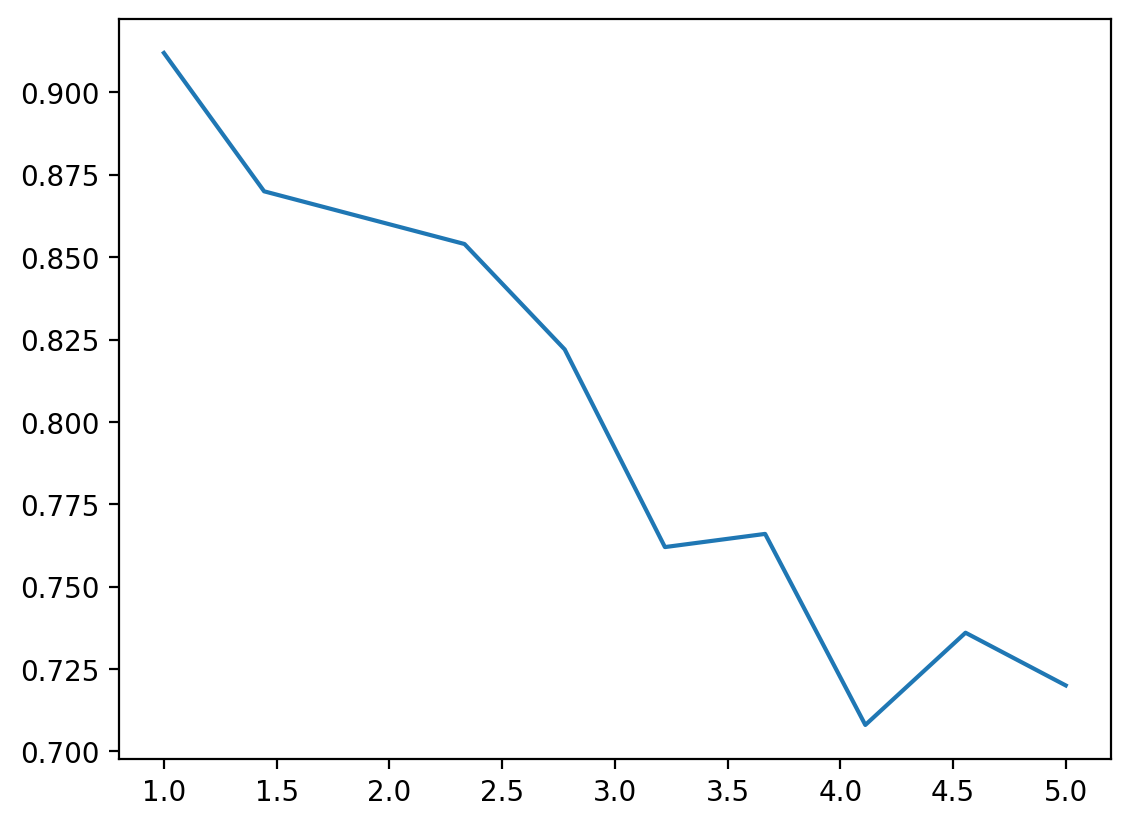

In [45]:
alpha = 1
beta = 1
gamma_vec = np.linspace(1,5,10)

## YOUR SOLUTION
n_repetitions = 10
gamma_to_accuracy = pd.DataFrame()
for gamma in gamma_vec:
    for _ in tqdm(range(n_repetitions)):
        v = PowerLossAversion(alpha, beta, gamma)
        pi = lambda p: p
        behavioral_env = BehavioralProspectEnvironment(v, pi)
        train_df, eval_df = behavioral_env.generate_train_eval_datasets(n_users_train=task_2_3_n_users)
        accuracies = []
        for _ in range(task_2_3_n_repetitions):
            model = sklearn.linear_model.LogisticRegression().fit(
                X=train_df[behavioral_env.feature_columns],
                y=train_df['behavioral_choice'],
            )
            accuracies.append(model.score(eval_df[behavioral_env.feature_columns], eval_df['behavioral_choice']))
    gamma_to_accuracy.loc[gamma, 'accuracy'] = np.mean(accuracies)

plt.plot(gamma_to_accuracy.index, gamma_to_accuracy['accuracy'])

Explain the results:

🔵 **Answer**:

Gamma makes u irretional and over sensitive to loss

Similarly, plot two lines representing the accuracy, for fixed $\gamma=\{1,2\}$ and variable $\alpha=\beta\in[0.4,1]$. Repeat each simulation 10 times for each value of $\gamma$, and average results.

🔵 **Answer**:

In [ ]:
alphabeta_vec = np.linspace(0.4,1,20)
gamma=[1,2]

## YOUR SOLUTION
for alpha in alphabeta_vec:
    for gam in gamma:
        beta = alpha
        v = PowerLossAversion(alpha, beta, gam)
        pi = lambda p: p
        behavioral_env = BehavioralProspectEnvironment(v, pi)
        train_df, eval_df = behavioral_env.generate_train_eval_datasets(n_users_train=task_2_3_n_users)
        accuracies = []
        for _ in tqdm(range(task_2_3_n_repetitions)):
            model = sklearn.linear_model.LogisticRegression().fit(
                X=train_df[behavioral_env.feature_columns],
                y=train_df['behavioral_choice'],
            )
            accuracies.append(model.score(eval_df[behavioral_env.feature_columns], eval_df['behavioral_choice']))

Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)


What can we conclude about the performance of a logistic regression classifier on behavioral data? What can explain the above observations?

🔵 **Answer**:

(YOUR SOLUTION)

# Task 3: Exploratory Analysis (Open-Ended)

We present three open-ended questions. Please choose one of them and answer in detail. **Bonus will be given for solving more than one question**.

This task is exploratory, and we encourage you to try different and creative approaches to solve it. In your answers, you should design and run appropriate experiment(s) - state your hypotheses, show plots that support your claim, and explain them.



## Option 1: Exploratory analysis (for Task \#1)


Looking at both measures (accuracy and welfare), try to vary the parameters of the experiment (\#users, \#items, \#features, environment parameters, etc.) in ways that show interesting trends. Explain your results in detail and support your claims.



## Option 2: Estimating behavioral deviations (for Task \#2)

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), propose a way to estimate the functional parameters $\alpha,\beta,\gamma$ from data. Support your claims using simulated data.



## Option 3: Accounting for behavioral deviations (for Task \#2)

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), improve predictive performance compared to the naive logistic regression baseline.

Support your claims using simulated data, and evaluate performance on behavioral models with parameters $\alpha, \beta, \gamma$ as defined in `prospect_params_lst` above.
Explain your methods. How did you train your model? Why?



## Open-ended question: Solution

Support your claims with data, explain your results, and maintain clarity. You are free to add code and Markdown cells.


🔵 **Answer**:

In [ ]:
## YOUR SOLUTION

Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)